#Movie Genre Prediction

Objective
The goal of this notebook is to design a predictive model that accurately classifies movies into their respective genres based on their titles and synopses.

https://huggingface.co/spaces/competitions/movie-genre-prediction

In [ ]:
!pip install transformers datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset
data = load_dataset("datadrivenscience/movie-genre-prediction")
data

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'movie_name', 'synopsis', 'genre'],
        num_rows: 54000
    })
    test: Dataset({
        features: ['id', 'movie_name', 'synopsis', 'genre'],
        num_rows: 36000
    })
})

In [ ]:
df = data["train"].to_pandas()
genre_list = df['genre'].unique()

id2label = {k: v for k, v in enumerate(genre_list)}

label2id = {k: v for v, k in enumerate(genre_list)}

In [ ]:
category_count = df['genre'].value_counts()

categories = category_count.index

categories

Index(['fantasy', 'horror', 'family', 'scifi', 'action', 'crime', 'adventure',
       'mystery', 'romance', 'thriller'],
      dtype='object')

In [ ]:
category_count

fantasy      5400
horror       5400
family       5400
scifi        5400
action       5400
crime        5400
adventure    5400
mystery      5400
romance      5400
thriller     5400
Name: genre, dtype: int64

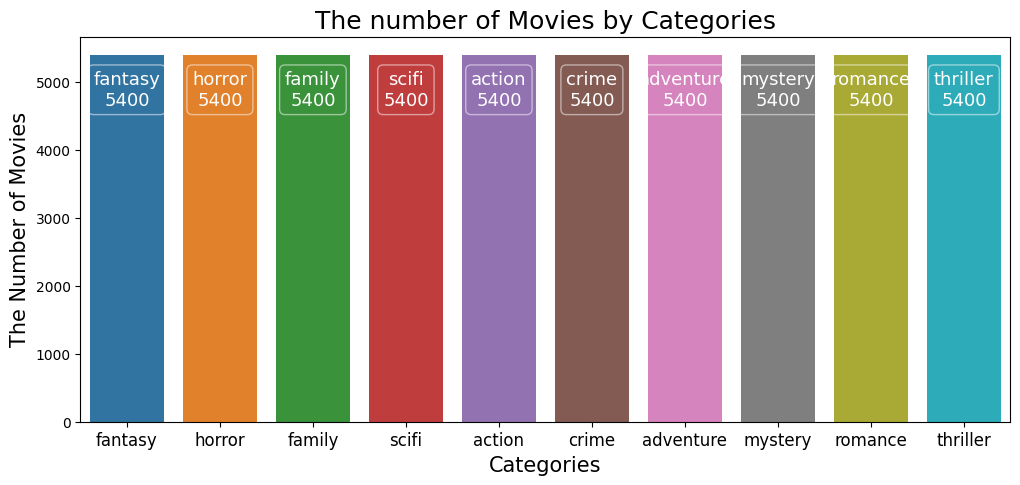

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of Movies', size= 15)

plt.xticks(size = 12)

plt.title("The number of Movies by Categories" , size = 18)

plt.show()

In [ ]:
id2label

{0: 'fantasy',
 1: 'horror',
 2: 'family',
 3: 'scifi',
 4: 'action',
 5: 'crime',
 6: 'adventure',
 7: 'mystery',
 8: 'romance',
 9: 'thriller'}

In [ ]:
label2id

{'fantasy': 0,
 'horror': 1,
 'family': 2,
 'scifi': 3,
 'action': 4,
 'crime': 5,
 'adventure': 6,
 'mystery': 7,
 'romance': 8,
 'thriller': 9}

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
import re

nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

# Define a function to clean the text
def clean_text(text):
  # convert text to lowercase
  text = text.lower()

  #text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
  #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
  text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text

  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def add_text(sample):
    sample["text"] =  clean_text(sample["movie_name"]) +'. '+ clean_text(sample["synopsis"])
    sample["label"] = label2id[sample['genre']]
    return sample

In [ ]:
updated_data = data.map(add_text)

Map:   0%|          | 0/54000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

In [ ]:
updated_data["test"][0]

{'id': 16863,
 'movie_name': 'A Death Sentence',
 'synopsis': "12 y.o. Ida's dad'll die without a DKK1,500,000 operation. Ida plans to steal the money from the bank, her mom installed alarm systems in. She'll need her climbing skills, her 2 friends and 3 go-karts.",
 'genre': 'action',
 'text': "death sentence. 12 y.o. ida's dad'll die without dkk1,500,000 operation. ida plans steal money bank, mom installed alarm systems in. she'll need climbing skills, 2 friends 3 go-karts.",
 'label': 4}

In [ ]:
updated_data["train"][0]

{'id': 44978,
 'movie_name': 'Super Me',
 'synopsis': 'A young scriptwriter starts bringing valuable objects back from his short nightmares of being chased by a demon. Selling them makes him rich.',
 'genre': 'fantasy',
 'text': 'super. young scriptwriter starts bringing valuable objects back short nightmares chased demon. selling makes rich.',
 'label': 0}

**Preprocess**

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_text = updated_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/54000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

**Evaluate**

In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Fine-tuning with the TFTrainer class

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=10, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.we

In [ ]:
!pip install accelerate -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 11.0 MB/s eta 0:00:00


In [ ]:
#train_test_ds = tokenized_text.train_test_split(test_size=0.1)

In [ ]:

training_args = TrainingArguments(
    output_dir="movie_genre_classification_model-v2",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    warmup_steps = 600,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_text["train"],
    eval_dataset=tokenized_text["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/dassum/movie_genre_classification_model-v2 into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/255M [00:00<?, ?B/s]

Download file runs/Jun22_12-41-19_466766a90608/events.out.tfevents.1687437684.466766a90608.47911.2: 100%|#####…

Download file runs/Jun22_10-43-24_466766a90608/events.out.tfevents.1687430616.466766a90608.16778.4: 100%|#####…

Download file runs/Jun22_09-57-10_466766a90608/events.out.tfevents.1687427865.466766a90608.16778.0: 100%|#####…

Download file runs/Jun22_10-29-18_466766a90608/events.out.tfevents.1687429831.466766a90608.16778.3: 100%|#####…

Download file runs/Jun22_12-26-21_466766a90608/events.out.tfevents.1687436788.466766a90608.47911.1: 100%|#####…

Download file runs/Jun22_10-16-42_466766a90608/events.out.tfevents.1687429055.466766a90608.16778.2: 100%|#####…

Download file runs/Jun22_12-58-24_466766a90608/events.out.tfevents.1687438711.466766a90608.47911.3: 100%|#####…

Download file training_args.bin: 100%|##########| 3.87k/3.87k [00:00<?, ?B/s]

Download file runs/Jun22_11-51-13_466766a90608/events.out.tfevents.1687434685.466766a90608.47911.0: 100%|#####…

Download file runs/Jun22_09-57-10_466766a90608/events.out.tfevents.1687428793.466766a90608.16778.1: 100%|#####…

Clean file runs/Jun22_12-41-19_466766a90608/events.out.tfevents.1687437684.466766a90608.47911.2:  14%|#4      …

Clean file runs/Jun22_12-26-21_466766a90608/events.out.tfevents.1687436788.466766a90608.47911.1:  19%|#9      …

Clean file runs/Jun22_10-29-18_466766a90608/events.out.tfevents.1687429831.466766a90608.16778.3:  18%|#7      …

Clean file runs/Jun22_09-57-10_466766a90608/events.out.tfevents.1687427865.466766a90608.16778.0:  14%|#4      …

Clean file runs/Jun22_10-43-24_466766a90608/events.out.tfevents.1687430616.466766a90608.16778.4:  14%|#4      …

Clean file runs/Jun22_12-58-24_466766a90608/events.out.tfevents.1687438711.466766a90608.47911.3:  15%|#4      …

Clean file runs/Jun22_10-16-42_466766a90608/events.out.tfevents.1687429055.466766a90608.16778.2:  16%|#6      …

Clean file training_args.bin:  26%|##5       | 1.00k/3.87k [00:00<?, ?B/s]

Clean file runs/Jun22_09-57-10_466766a90608/events.out.tfevents.1687428793.466766a90608.16778.1: 100%|########…

Clean file runs/Jun22_11-51-13_466766a90608/events.out.tfevents.1687434685.466766a90608.47911.0:  20%|#9      …

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.676000,2.931875,0.077278
2,1.509500,2.962938,0.093611
3,1.381900,3.326962,0.076639
4,1.207700,3.511744,0.080861
5,1.045800,3.943530,0.101083
6,0.913200,4.259548,0.086083
7,0.802000,5.039279,0.077333
8,0.709500,5.524723,0.078472
9,0.635200,5.081073,0.112500
10,0.603000,6.613667,0.063194


TrainOutput(global_step=101250, training_loss=0.5521051030288507, metrics={'train_runtime': 5678.2889, 'train_samples_per_second': 285.297, 'train_steps_per_second': 17.831, 'total_flos': 1.88701392926784e+16, 'train_loss': 0.5521051030288507, 'epoch': 30.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 2.931875228881836,
 'eval_accuracy': 0.07727777777777778,
 'eval_runtime': 25.0115,
 'eval_samples_per_second': 1439.34,
 'eval_steps_per_second': 89.959,
 'epoch': 30.0}

In [ ]:
trainer.push_to_hub()

Upload file runs/Jun24_14-19-44_02695a77bf07/events.out.tfevents.1687616462.02695a77bf07.4732.0:   0%|        …

Upload file runs/Jun24_14-19-44_02695a77bf07/events.out.tfevents.1687622175.02695a77bf07.4732.1:   0%|        …

To https://huggingface.co/dassum/movie_genre_classification_model-v2
   f9d588a..4d289f3  main -> main

   f9d588a..4d289f3  main -> main

To https://huggingface.co/dassum/movie_genre_classification_model-v2
   4d289f3..6c9749a  main -> main

   4d289f3..6c9749a  main -> main



'https://huggingface.co/dassum/movie_genre_classification_model-v2/commit/4d289f38853ebed812ca2b7421590e3cf365c938'

**Loading Pre-Trained Model**

In [ ]:
text = "death sentence. yo idas dadll die without operation ida plans steal money bank mom installed alarm systems shell need climbing skills friends gokarts"

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dassum/movie_genre_classification_model-v2")
inputs = tokenizer(text, return_tensors="pt")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:4                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'text' is not defined

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("dassum/movie_genre_classification_model-v2")
with torch.no_grad():
    logits = model(**inputs).logits

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:6                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'inputs' is not defined

In [ ]:
predicted_class_id = logits.argmax().item()
predicted_class_id

2

In [ ]:
model.config.id2label[predicted_class_id]

'family'

In [ ]:

df = updated_data['test'].to_pandas()
data_texts = df['text'].to_list()
test_ids = df['id'].to_list()


In [ ]:
predictions = []
from transformers import pipeline

classifier = pipeline(model="dassum/movie_genre_classification_model-v2",framework='pt', device=0)
for idx, x in enumerate(data_texts):
  prediction_value_pt = classifier(x)
  label = prediction_value_pt[0]['label']
  predictions.append(label)
  print(idx)

print(predictions[0])

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Streaming output truncated to the last 5000 lines.
31001
31002
31003
31004
31005
31006
31007
31008
31009
31010
31011
31012
31013
31014
31015
31016
31017
31018
31019
31020
31021
31022
31023
31024
31025
31026
31027
31028
31029
31030
31031
31032
31033
31034
31035
31036
31037
31038
31039
31040
31041
31042
31043
31044
31045
31046
31047
31048
31049
31050
31051
31052
31053
31054
31055
31056
31057
31058
31059
31060
31061
31062
31063
31064
31065
31066
31067
31068
31069
31070
31071
31072
31073
31074
31075
31076
31077
31078
31079
31080
31081
31082
31083
31084
31085
31086
31087
31088
31089
31090
31091
31092
31093
31094
31095
31096
31097
31098
31099
31100
31101
31102
31103
31104
31105
31106
31107
31108
31109
31110
31111
31112
31113
31114
31115
31116
31117
31118
31119
31120
31121
31122
31123
31124
31125
31126
31127
31128
31129
31130
31131
31132
31133
31134
31135
31136
31137
31138
31139
31140
31141
31142
31143
31144
31145
31146
31147
31148
31149
31150
31151
31152
31153
31154
31155
31156
31157
31158
3

In [ ]:
import numpy as np
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%s'],
    delimiter=',',
    header='id,genre',
    comments='',
)

In [ ]:
updated_data = data.map(add_text)

Map:   0%|          | 0/54000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

In [ ]:
train_data = updated_data["train"].to_pandas()
test_data = updated_data["test"].to_pandas()

In [ ]:
train_data

,id,movie_name,synopsis,genre,text,label
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy,super. young scriptwriter starts bringing valu...,0
1,50185,Entity Project,A director and her friends renting a haunted h...,horror,entity project. director friends renting haunt...,1
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family,behavioral family therapy serious psychiatric ...,2
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi,blood glacier. scientists working austrian alp...,3
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action,apat na anino. buy day four men widely apart l...,4
...,...,...,...,...,...,...
53995,80325,Untitled Monkeyshine/Ugly Brother Project,Two loser pest control buddies find themselves...,scifi,untitled monkeyshine ugly brother project. two...,3
53996,84712,The Great Swindle,A seductive woman gets involved in relationshi...,thriller,great swindle. seductive woman gets involved r...,9
53997,69801,When Men Get Pregnant,"Duyen, a wedding dress staff, who decides to c...",romance,men get pregnant. duyen wedding dress staff de...,8
53998,7678,Suttu Pidikka Utharavu,The people of a crowded colony in Coimbatore c...,action,suttu pidikka utharavu. people crowded colony ...,4


In [ ]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(train_data) * .7)
#train_text = train_data['text'][:train_size]
#train_tags = train_data['genre'][:train_size]

train_text = train_data['text']
train_tags = train_data['genre']

#test_text = train_data['text'][train_size:]
#test_tags = train_data['genre'][train_size:]

test_text = test_data['text']
test_tags = test_data['genre']

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_text) # only fit on train

x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 3

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/3
1519/1519 [==============================] - 6s 4ms/step - loss: 1.9707 - accuracy: 0.2991 - val_loss: 1.8554 - val_accuracy: 0.3448
Epoch 2/3
1519/1519 [==============================] - 6s 4ms/step - loss: 1.8001 - accuracy: 0.3649 - val_loss: 1.8560 - val_accuracy: 0.3394
Epoch 3/3
1519/1519 [==============================] - 5s 3ms/step - loss: 1.7132 - accuracy: 0.3933 - val_loss: 1.8640 - val_accuracy: 0.3387


In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

1125/1125 [==============================] - 3s 3ms/step - loss: 2.7960 - accuracy: 0.0935
Test accuracy: 0.09347222000360489


In [ ]:
probabilities = model.predict(x_test)
predictions = np.argmax(probabilities, axis=-1)
predicted_labels=encoder.inverse_transform(predictions)
predicted_labels

1125/1125 [==============================] - 3s 2ms/step


array(['crime', 'horror', 'fantasy', ..., 'adventure', 'thriller',
       'romance'], dtype=object)

In [ ]:
test_ids=test_data["id"].to_list()

In [ ]:
import numpy as np
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predicted_labels]),
    fmt=['%s', '%s'],
    delimiter=',',
    header='id,genre',
    comments='',
)

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli",framework='pt', device=0)

In [ ]:
sequence_to_classify = "death sentence. yo idas dadll die without operation ida plans steal money bank mom installed alarm systems shell need climbing skills friends gokarts"
candidate_labels = ['fantasy', 'horror', 'family','scifi','action','crime','adventure','mystery','romance','thriller']
response = classifier(sequence_to_classify, candidate_labels)
print(response['labels'])
print(response['scores'])

['action', 'family', 'crime', 'horror', 'adventure', 'mystery', 'thriller', 'fantasy', 'scifi', 'romance']
[0.296210914850235, 0.2911483347415924, 0.16214530169963837, 0.1134934201836586, 0.060539305210113525, 0.03558327630162239, 0.023443985730409622, 0.010741922073066235, 0.004369695205241442, 0.0023237373679876328]


In [ ]:
test_data = updated_data["test"].to_pandas()
test_data.head()

,id,movie_name,synopsis,genre,text,label
0,16863,A Death Sentence,"12 y.o. Ida's dad'll die without a DKK1,500,00...",action,death sentence. 12 yo idas dadll die without d...,4
1,48456,Intermedio,A group of four teenage friends become trapped...,action,intermedio. group four teenage friends become ...,4
2,41383,30 Chua Phai Tet,A guy left his home for 12 years till he came ...,action,30 chua phai tet. guy left home 12 years till ...,4
3,84007,Paranoiac,A man long believed dead returns to the family...,action,paranoiac. man long believed dead returns fami...,4
4,40269,Ordinary Happiness,"After a deadly accident, Paolo comes back on E...",action,ordinary happiness. deadly accident paolo come...,4


In [ ]:
test_ids =[]
predictions=[]
candidate_labels = ['fantasy', 'horror', 'family','scifi','action','crime','adventure','mystery','romance','thriller']
for idx, x in test_data.iterrows():
  predicted_resp = classifier(x['text'],candidate_labels)
  scores = predicted_resp['scores']
  max_index = scores.index(max(scores))
  labels = predicted_resp['labels']
  test_ids.append(x['id'])
  predictions.append(labels[max_index])
  print(idx)


0
1
2
3
4
5
6
7
8
9


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Streaming output truncated to the last 5000 lines.
31000
31001
31002
31003
31004
31005
31006
31007
31008
31009
31010
31011
31012
31013
31014
31015
31016
31017
31018
31019
31020
31021
31022
31023
31024
31025
31026
31027
31028
31029
31030
31031
31032
31033
31034
31035
31036
31037
31038
31039
31040
31041
31042
31043
31044
31045
31046
31047
31048
31049
31050
31051
31052
31053
31054
31055
31056
31057
31058
31059
31060
31061
31062
31063
31064
31065
31066
31067
31068
31069
31070
31071
31072
31073
31074
31075
31076
31077
31078
31079
31080
31081
31082
31083
31084
31085
31086
31087
31088
31089
31090
31091
31092
31093
31094
31095
31096
31097
31098
31099
31100
31101
31102
31103
31104
31105
31106
31107
31108
31109
31110
31111
31112
31113
31114
31115
31116
31117
31118
31119
31120
31121
31122
31123
31124
31125
31126
31127
31128
31129
31130
31131
31132
31133
31134
31135
31136
31137
31138
31139
31140
31141
31142
31143
31144
31145
31146
31147
31148
31149
31150
31151
31152
31153
31154
31155
31156
31157
3

In [ ]:
import numpy as np
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%s'],
    delimiter=',',
    header='id,genre',
    comments='',
)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

test_data = updated_data["test"].to_pandas()
test_data.rename(columns={'genre':'y_true'}, inplace=True)

test_data = test_data[["id","y_true"]]
test_data.head()



,id,y_true
0,16863,action
1,48456,action
2,41383,action
3,84007,action
4,40269,action


In [ ]:
predictions_df = pd.read_csv('submission.csv')
predictions_df.rename(columns={'genre':'y_pred'}, inplace=True)
predictions_df = predictions_df[["id","y_pred"]]
predictions_df.head()

,id,y_pred
0,16863,action
1,48456,horror
2,41383,action
3,84007,fantasy
4,40269,action


In [ ]:
merged_df = pd.merge(test_data, predictions_df, on='id')

In [ ]:
y_pred = merged_df['y_pred'].tolist()
y_true = merged_df['y_true'].tolist()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.42127777777777775